https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/


Sequence-to-sequence


https://wikidocs.net/24996

context vector : 인코더는 입력 문장의 모든 단어들을 순차적으로 입력받은 뒤에 마지막에 이 모든 단어 정보들을 압축해서 하나의 벡터로 만드는데, 이를 컨텍스트 벡터(context vector)라고 합니다.


-It made it challenging for the models to deal with long sentences.

문제점 때문에 attention 만들어짐



Attention


 Attention allows the model to focus on the relevant parts of the input sequence as needed.


An attention model differs from a classic sequence-to-sequence model in two main ways:

First, the encoder passes a lot more data to the decoder. Instead of passing the last hidden state of the encoding stage, the encoder passes all the hidden states to the decoder:





중요
Second, an attention decoder does an extra step before producing its output. In order to focus on the parts of the input that are relevant to this decoding time step, the decoder does the following:

1.Look at the set of encoder hidden states it received – each encoder hidden state is most associated with a certain word in the input sentence
2.Give each hidden state a score (let’s ignore how the scoring is done for now)
3.Multiply each hidden state by its softmaxed score, thus amplifying hidden states with high scores, and drowning out hidden states with low scores



https://wikidocs.net/31379

트랜스포머

어텐션(Attention)만으로 구현한 모델입니다. 이 모델은 RNN을 사용하지 않고, 인코더-디코더 구조를 설계하였음에도 번역 성능에서도 RNN보다 우수한 성능을 보여주었습니다.


 여러 개로 분할해서 병렬로 어텐션을 수행하고 결과값을 다시 하나로 합치는 방식을 택했습니다.
 
 ->빠르게 수행하기 위해
 
 
 
 
https://jalammar.github.io/illustrated-transformer/
 
 
RNN에서는 w공유되어 값이 다 같음


The encoders are all identical in structure (yet they do not share weights).
transform에서는 weight가 다르다


a layer that helps the encoder look at other words in the input sentence as it encodes a specific word.
인코더에서 다른 단어들과 어떤 연관이 있는지 살펴봄


The embedding only happens in the bottom-most encoder. 처음에만 임베딩함




 self attention allows it to look at other positions in the input sequence for clues that can help lead to a better encoding for this word.
 
 Self-attention is the method the Transformer uses to bake the “understanding” of other relevant words into the one we’re currently processing.
 
 
 
 
 Self-Attention in Detail
 
 
 
  Query vector, a Key vector, and a Value vector. These vectors are created by multiplying the embedding by three matrices that we trained during the training process.
  
  
  그림에서 맨 오른쪽 가중치 행렬이라고 부름
 
 
Query vector, a Key vector, and a Value vector. These vectors are created by multiplying the embedding by three matrices that we trained during the training process.

Query vector, a Key vector, and a Value vector ->가중치 벡터


second step
어떤 단어에 집중해야할 지 결정



Thinking이라는 단어에 Machines 단어의 정보도 어느정도 들어가있음
어떤 단어에 대해서 같이 사용되는 주변 단어의 정보도 필요하다->?


softmax에 value곱하는 이유 : 필요한 값은 값 크게 줘서 값 크게 나오고 중요하지 않은 단어는 곱해서 없애려고
softmax를 곱하는 것

The fifth step is to multiply each value vector by the softmax score (in preparation to sum them up). The intuition here is to keep intact the values of the word(s) we want to focus on, and drown-out irrelevant words (by multiplying them by tiny numbers like 0.001, for example).


value벡터도 학습을 통해 얻어지는 것

X의 각 칸->단어


어떤 단어와 관련이 있는지 표현 가능



The Beast With Many Heads

“multi-headed” attention. ->attention head가 여러개 있다


 z1 contains a little bit of every other encoding, but it could be dominated by the actual word itself.
 당연히 자기 자신을 제일 높게 평가
 
 
 
 representation subspaces
 여러 각도로 어떤 단어와 그 주변을 형성하는 단어들 사이의 관계를 표현
 
 
 Positional Encoding
 단어의 순서도 중요하다
 정확한 번역 위해 순서도 인코딩해야함
 어떻게 할 것인가->Positional Encoding
 
 위치를  가볍게 표현하기 위해 사인과 코사인함수 이용해 위치 나타냄
 
 


 https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
Sequence-to-sequence


In [1]:
import os
import shutil
import zipfile

import pandas as pd
import tensorflow as tf
import urllib3
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [2]:
import requests

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

def download_zip(url, output_path):
    response = requests.get(url, headers=headers, stream=True)
    if response.status_code == 200:
        with open(output_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"ZIP file downloaded to {output_path}")
    else:
        print(f"Failed to download. HTTP Response Code: {response.status_code}")

url = "http://www.manythings.org/anki/fra-eng.zip"
output_path = "fra-eng.zip"
download_zip(url, output_path)

path = os.getcwd()
zipfilename = os.path.join(path, output_path)

with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
    zip_ref.extractall(path)

ZIP file downloaded to fra-eng.zip


In [3]:
lines = pd.read_csv('fra.txt', names=['src', 'tar', 'lic'], sep='\t') #공백문자 탭으로 이루어짐
del lines['lic']
print('전체 샘플의 개수 :',len(lines))

전체 샘플의 개수 : 227815


In [4]:
lines

,src,tar
0,Go.,Va !
1,Go.,Marche.
2,Go.,En route !
3,Go.,Bouge !
4,Hi.,Salut !
...,...,...
227810,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...
227811,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...
227812,If someone who doesn't know your background sa...,Si quelqu'un qui ne connaît pas vos antécédent...
227813,It may be impossible to get a completely error...,Il est peut-être impossible d'obtenir un Corpu...


In [5]:
lines = lines.loc[:, 'src':'tar']
lines = lines[0:60000] # 6만개만 저장
lines.sample(10)

,src,tar
5238,I got soaked.,Je me suis fait tremper.
47300,He devoured his meal.,Il dévora son repas.
59254,She has a slight lisp.,Elle zézaie légèrement.
29261,There is a strike.,Il y a une grève.
56609,I got what I came for.,J'ai obtenu ce pourquoi je suis venu.
7131,Ask Tom again.,Redemandez à Tom.
38031,Why can't Tom come?,Pourquoi Tom ne peut-il pas venir ?
33705,I looked around me.,J'ai regardé autour de moi.
43377,That's really great.,C'est vraiment super.
16202,I'm open-minded.,Je suis ouvert d'esprit.


In [6]:
lines.tar = lines.tar.apply(lambda x : '\t '+ x + ' \n') #시작 + x + 종료
lines.sample(10)


,src,tar
23119,This is not true.,\t C'est pas vrai. \n
11560,I punished Tom.,\t J'ai puni Tom. \n
42702,No one's allowed in.,\t Personne n'est admis. \n
46396,Can I close the door?,\t Je peux fermer la porte ? \n
41224,I tested everything.,\t J'ai tout testé. \n
33732,I love summer rain.,\t J'aime la pluie d'été. \n
59642,That's a nice thought.,\t C'est bien pensé. \n
44053,Tom doesn't like us.,\t Tom ne nous aime pas. \n
41500,I would've said yes.,\t J’aurais dit oui. \n
58379,It feels like a dream.,\t On se croit dans un rêve. \n


In [7]:
#토큰의 단위를 문자로 하면 문자를 예측
#문장으로 하면 문장 단위로 예측


# 문자 집합 구축
src_vocab = set()
for line in lines.src: # 1줄씩 읽음
    for char in line: # 1개의 문자씩 읽음
        src_vocab.add(char)

In [9]:
src_vocab

{' ',
 '!',
 '"',
 '$',
 '%',
 '&',
 "'",
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 'é',
 'ï',
 '’',
 '€'}

In [10]:
tar_vocab = set()
for line in lines.tar:
    for char in line:
        tar_vocab.add(char)

In [11]:
tar_vocab

{'\t',
 '\n',
 ' ',
 '!',
 '"',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 ',',
 '-',
 '.',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '\xa0',
 '«',
 '»',
 'À',
 'Ç',
 'É',
 'Ê',
 'Ô',
 'à',
 'â',
 'ç',
 'è',
 'é',
 'ê',
 'ë',
 'î',
 'ï',
 'ô',
 'ù',
 'û',
 'œ',
 '\u2009',
 '‘',
 '’',
 '\u202f',
 '‽'}

In [13]:
src_vocab_size = len(src_vocab)+1
tar_vocab_size = len(tar_vocab)+1
print('source 문장의 char 집합 :',src_vocab_size) #영어
print('target 문장의 char 집합 :',tar_vocab_size) #프랑스어

source 문장의 char 집합 : 80
target 문장의 char 집합 : 104


In [16]:
src_vocab=sorted(list(src_vocab))
src_vocab #아스키코드 순으로 정렬

[' ',
 '!',
 '"',
 '$',
 '%',
 '&',
 "'",
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 'é',
 'ï',
 '’',
 '€']

In [17]:
tar_vocab = sorted(list(tar_vocab))
tar_vocab

['\t',
 '\n',
 ' ',
 '!',
 '"',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 ',',
 '-',
 '.',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '\xa0',
 '«',
 '»',
 'À',
 'Ç',
 'É',
 'Ê',
 'Ô',
 'à',
 'â',
 'ç',
 'è',
 'é',
 'ê',
 'ë',
 'î',
 'ï',
 'ô',
 'ù',
 'û',
 'œ',
 '\u2009',
 '‘',
 '’',
 '\u202f',
 '‽']

In [18]:
src_to_index = dict([(word, i+1) for i, word in enumerate(src_vocab)])
tar_to_index = dict([(word, i+1) for i, word in enumerate(tar_vocab)])
print(src_to_index)

{' ': 1, '!': 2, '"': 3, '$': 4, '%': 5, '&': 6, "'": 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, '?': 23, 'A': 24, 'B': 25, 'C': 26, 'D': 27, 'E': 28, 'F': 29, 'G': 30, 'H': 31, 'I': 32, 'J': 33, 'K': 34, 'L': 35, 'M': 36, 'N': 37, 'O': 38, 'P': 39, 'Q': 40, 'R': 41, 'S': 42, 'T': 43, 'U': 44, 'V': 45, 'W': 46, 'X': 47, 'Y': 48, 'Z': 49, 'a': 50, 'b': 51, 'c': 52, 'd': 53, 'e': 54, 'f': 55, 'g': 56, 'h': 57, 'i': 58, 'j': 59, 'k': 60, 'l': 61, 'm': 62, 'n': 63, 'o': 64, 'p': 65, 'q': 66, 'r': 67, 's': 68, 't': 69, 'u': 70, 'v': 71, 'w': 72, 'x': 73, 'y': 74, 'z': 75, 'é': 76, 'ï': 77, '’': 78, '€': 79}


In [19]:
print(tar_to_index)

{'\t': 1, '\n': 2, ' ': 3, '!': 4, '"': 5, '$': 6, '%': 7, '&': 8, "'": 9, '(': 10, ')': 11, ',': 12, '-': 13, '.': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, '?': 26, 'A': 27, 'B': 28, 'C': 29, 'D': 30, 'E': 31, 'F': 32, 'G': 33, 'H': 34, 'I': 35, 'J': 36, 'K': 37, 'L': 38, 'M': 39, 'N': 40, 'O': 41, 'P': 42, 'Q': 43, 'R': 44, 'S': 45, 'T': 46, 'U': 47, 'V': 48, 'W': 49, 'X': 50, 'Y': 51, 'a': 52, 'b': 53, 'c': 54, 'd': 55, 'e': 56, 'f': 57, 'g': 58, 'h': 59, 'i': 60, 'j': 61, 'k': 62, 'l': 63, 'm': 64, 'n': 65, 'o': 66, 'p': 67, 'q': 68, 'r': 69, 's': 70, 't': 71, 'u': 72, 'v': 73, 'w': 74, 'x': 75, 'y': 76, 'z': 77, '\xa0': 78, '«': 79, '»': 80, 'À': 81, 'Ç': 82, 'É': 83, 'Ê': 84, 'Ô': 85, 'à': 86, 'â': 87, 'ç': 88, 'è': 89, 'é': 90, 'ê': 91, 'ë': 92, 'î': 93, 'ï': 94, 'ô': 95, 'ù': 96, 'û': 97, 'œ': 98, '\u2009': 99, '‘': 100, '’': 101, '\u202f': 102, '‽': 103}


In [20]:
#영어 문장 인코딩


In [21]:
encoder_input = []


In [23]:
lines.src

0                           Go.
1                           Go.
2                           Go.
3                           Go.
4                           Hi.
                  ...          
59995    These are my students.
59996    These aren't my ideas.
59997    These books are Tom's.
59998    These books are heavy.
59999    These boxes are heavy.
Name: src, Length: 60000, dtype: object

In [24]:
for line in lines.src:
    encoded_line=[]
    for c in line:
        encoded_line.append(src_to_index[c])
    encoder_input.append(encoded_line)

In [26]:
encoder_input

[[30, 64, 10],
 [30, 64, 10],
 [30, 64, 10],
 [30, 64, 10],
 [31, 58, 10],
 [31, 58, 10],
 [41, 70, 63, 2],
 [41, 70, 63, 2],
 [41, 70, 63, 2],
 [41, 70, 63, 2],
 [41, 70, 63, 2],
 [41, 70, 63, 2],
 [41, 70, 63, 2],
 [41, 70, 63, 2],
 [41, 70, 63, 10],
 [41, 70, 63, 10],
 [41, 70, 63, 10],
 [41, 70, 63, 10],
 [41, 70, 63, 10],
 [41, 70, 63, 10],
 [41, 70, 63, 10],
 [41, 70, 63, 10],
 [46, 57, 64, 23],
 [46, 64, 72, 2],
 [46, 64, 72, 2],
 [46, 64, 72, 2],
 [27, 70, 52, 60, 2],
 [27, 70, 52, 60, 2],
 [27, 70, 52, 60, 2],
 [29, 58, 67, 54, 2],
 [31, 54, 61, 65, 2],
 [31, 58, 53, 54, 10],
 [31, 58, 53, 54, 10],
 [33, 70, 62, 65, 2],
 [33, 70, 62, 65, 10],
 [42, 69, 64, 65, 2],
 [42, 69, 64, 65, 2],
 [42, 69, 64, 65, 2],
 [46, 50, 58, 69, 2],
 [46, 50, 58, 69, 2],
 [46, 50, 58, 69, 2],
 [46, 50, 58, 69, 10],
 [46, 50, 58, 69, 10],
 [46, 50, 58, 69, 10],
 [46, 50, 58, 69, 10],
 [25, 54, 56, 58, 63, 10],
 [25, 54, 56, 58, 63, 10],
 [30, 64, 1, 64, 63, 10],
 [30, 64, 1, 64, 63, 10],
 [30, 64, 

In [27]:
decoder_input = []
for line in lines.tar:
  encoded_line = []
  for char in line:
    encoded_line.append(tar_to_index[char])
  decoder_input.append(encoded_line)
print('target 문장의 정수 인코딩 :',decoder_input[:5])

target 문장의 정수 인코딩 : [[1, 3, 48, 52, 3, 4, 3, 2], [1, 3, 39, 52, 69, 54, 59, 56, 14, 3, 2], [1, 3, 31, 65, 3, 69, 66, 72, 71, 56, 3, 4, 3, 2], [1, 3, 28, 66, 72, 58, 56, 3, 4, 3, 2], [1, 3, 45, 52, 63, 72, 71, 3, 4, 3, 2]]


In [29]:
#\t제거 작업

decoder_target = []
for line in lines.tar:
  timestep = 0
  encoded_line = []
  for char in line:
    if timestep > 0:
      encoded_line.append(tar_to_index[char])
    timestep = timestep + 1
  decoder_target.append(encoded_line)
print('target 문장 레이블의 정수 인코딩 :',decoder_target[:5])

#1이 다 빠짐

target 문장 레이블의 정수 인코딩 : [[3, 48, 52, 3, 4, 3, 2], [3, 39, 52, 69, 54, 59, 56, 14, 3, 2], [3, 31, 65, 3, 69, 66, 72, 71, 56, 3, 4, 3, 2], [3, 28, 66, 72, 58, 56, 3, 4, 3, 2], [3, 45, 52, 63, 72, 71, 3, 4, 3, 2]]


In [30]:
#길이 동일하게 맞추는 padding 작업

In [31]:
max_src_len = max([len(line) for line in lines.src])
max_tar_len = max([len(line) for line in lines.tar])
print('source 문장의 최대 길이 :',max_src_len)
print('target 문장의 최대 길이 :',max_tar_len)

source 문장의 최대 길이 : 22
target 문장의 최대 길이 : 76


In [32]:
#패딩을 할 때 영어와 프랑스어 따로 따로 해줌


In [33]:
encoder_input = pad_sequences(encoder_input, maxlen=max_src_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_tar_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_tar_len, padding='post')

In [35]:
#문자단위로 원핫인코딩
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

In [38]:
encoder_input.shape  #( ,문장 최대 길이,문자종류)

(60000, 22, 80)

In [40]:
decoder_input.shape

(60000, 76, 104)

In [41]:
decoder_target.shape

(60000, 76, 104)

In [42]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
import numpy as np

In [49]:
#Seq2Seq 인코더 설계

In [43]:
encoder_inputs = Input(shape=(None, src_vocab_size))

In [45]:
encoder_lstm=LSTM(units=256, return_state=True)
#encoder 부분 설계

In [44]:
 src_vocab_size
#문자 벡터의 크기
#문자가 80차원

80

In [46]:
encoder_outputs, state_h, state_c =encoder_lstm(encoder_inputs)
#state_h(은닉상태), state_c(셀 상태)

In [48]:
encoder_states = [state_h, state_c] #encoder_states : 컨텍스트 벡터

In [50]:
#Seq2Seq 디코더 설계

In [51]:
decoder_inputs = Input(shape=(None, tar_vocab_size))

In [54]:
decoder_lstm=LSTM(units=256, return_state=True,return_sequences=True)
#위에서와 달리 번역결과가 나와야하므로 return_sequences=True 로 설정

In [55]:
decoder_outputs,_,_=decoder_lstm(decoder_inputs, initial_state=encoder_states)
#디코더는 은닉상태, 셀 상태 정보가 필요 없음(훈련과정에서는)

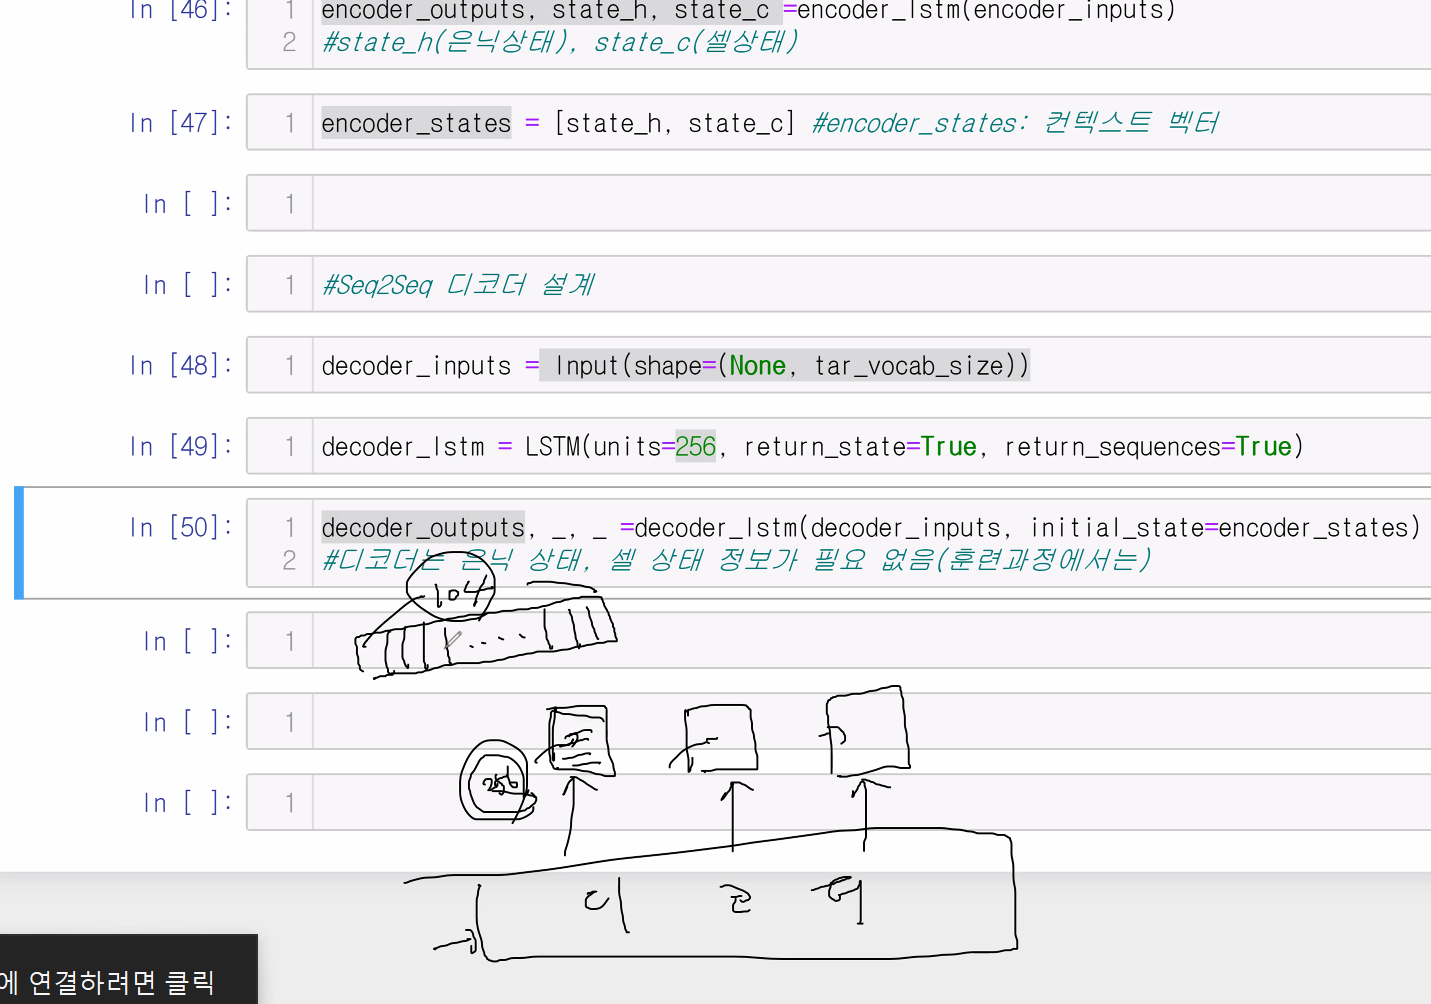

In [56]:
decoder_softmax_layer = Dense(tar_vocab_size, activation='softmax')

In [57]:
decoder_outputs=decoder_softmax_layer(decoder_outputs)

In [58]:
model=Model([encoder_inputs,decoder_inputs],decoder_outputs)

In [59]:
model.compile(optimizer='rmsprop', loss="categorical_crossentropy")

In [60]:
model.fit(x=[encoder_input,decoder_input],y=decoder_target,batch_size=64,epochs=40,validation_split=0.2)

Epoch 1/40
750/750 [==============================] - 124s 162ms/step - loss: 0.8492 - val_loss: 0.7768
Epoch 2/40
750/750 [==============================] - 120s 160ms/step - loss: 0.5746 - val_loss: 0.6583
Epoch 3/40
750/750 [==============================] - 120s 159ms/step - loss: 0.5045 - val_loss: 0.5992
Epoch 4/40
750/750 [==============================] - 123s 164ms/step - loss: 0.4578 - val_loss: 0.5613
Epoch 5/40
750/750 [==============================] - 130s 173ms/step - loss: 0.4212 - val_loss: 0.5163
Epoch 6/40
750/750 [==============================] - 133s 177ms/step - loss: 0.3928 - val_loss: 0.4989
Epoch 7/40
750/750 [==============================] - 132s 176ms/step - loss: 0.3718 - val_loss: 0.4721
Epoch 8/40
750/750 [==============================] - 133s 177ms/step - loss: 0.3552 - val_loss: 0.4511
Epoch 9/40
750/750 [==============================] - 132s 176ms/step - loss: 0.3414 - val_loss: 0.4389
Epoch 10/40
750/750 [==============================] - 133s 178m

In [63]:
#문장 입력시 번역된 문장 나오도록 해야함

#테스트 과정
1.번역 대상 입력 문장이 인코더에 들어감 -> 은닉정보/셀 상태 정보 리턴 -> 디코더로 전달
2.디코더의 입력 시그널이 전달(sos,\t)
3.디코더는 다음 문자 예측
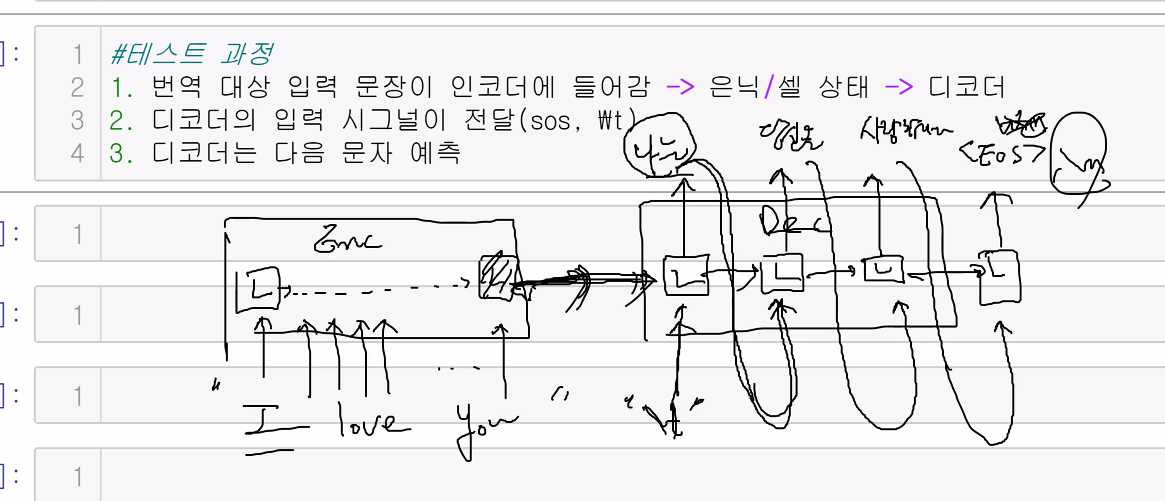

In [64]:
# 테스트 과정에서의 디코더 정의

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용.
# 뒤의 함수 decode_sequence()에 동작을 구현 예정
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태를 버리지 않음.
decoder_states = [state_h, state_c]
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)

In [65]:
#테스트 과정에서의 인코더 정의
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)

In [111]:
index_to_src = dict((i, char) for char, i in src_to_index.items())
index_to_tar = dict((i, char) for char, i in tar_to_index.items())

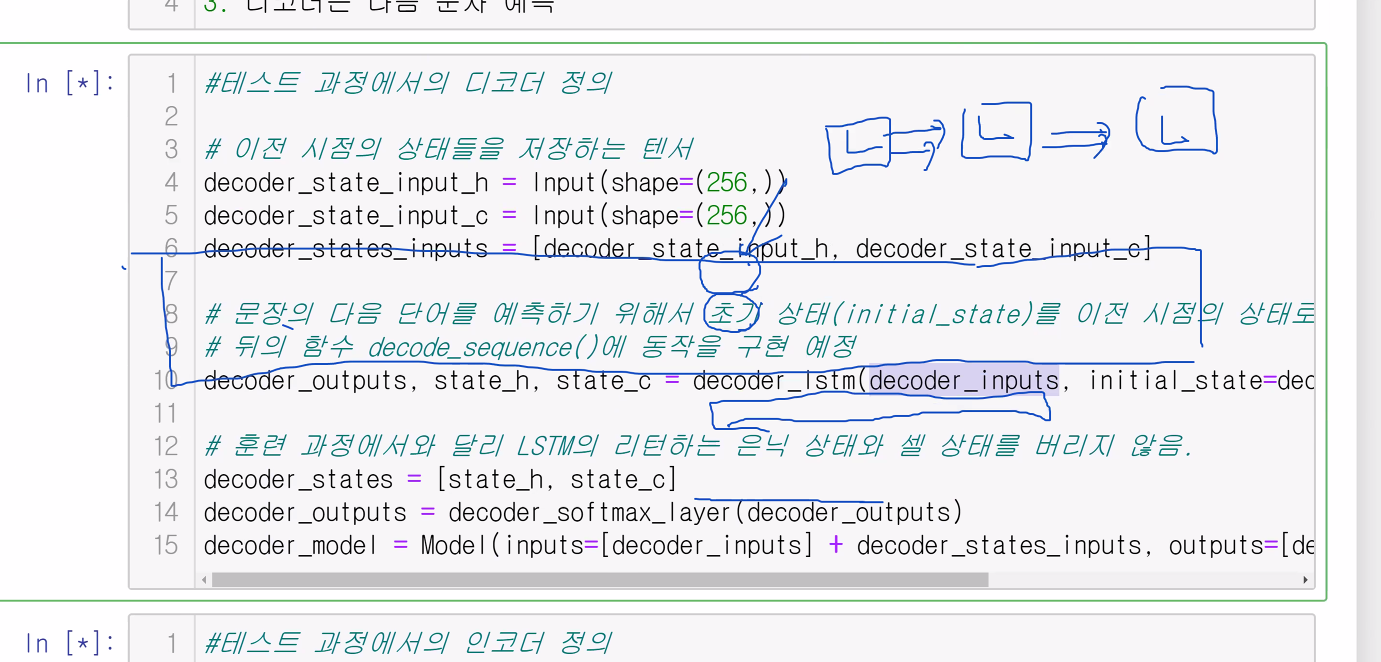

In [114]:
def decode_sequence(input_seq):
  # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)
  # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, tar_vocab_size))
    target_seq[0, 0, tar_to_index['\t']] = 1.
    stop_condition = False
    decoded_sentence = ""
  # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
    # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]
    # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += sampled_char
    # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or len(decoded_sentence) > max_tar_len):
            stop_condition = True
    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1, tar_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.
    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]
    return decoded_sentence

In [115]:
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스
  input_seq = encoder_input[seq_index:seq_index+1]
  decoded_sentence = decode_sequence(input_seq) #번역문
  print(35 * "-")
  print('입력 문장:', lines.src[seq_index])
  print('정답 문장:', lines.tar[seq_index][2:len(lines.tar[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
  print('번역 문장:', decoded_sentence[1:len(decoded_sentence)-1]) # '\n'을 빼고 출력

1/1 [==============================] - 0s 23ms/step
-----------------------------------
입력 문장: Go.
정답 문장: Bouge ! 
번역 문장: Partez ! 
1/1 [==============================] - 0s 16ms/step
-----------------------------------
입력 문장: Hello!
정답 문장: Bonjour ! 
번역 문장: Salut ! 
1/1 [==============================] - 0s 16ms/step
-----------------------------------
입력 문장: Got it!
정답 문장: J'ai pigé ! 
번역 문장: Attrapez ! 
1/1 [==============================] - 0s 22ms/step
-----------------------------------
입력 문장: Go home.
정답 문장: Rentre à la maison. 
번역 문장: Va ! 
1/1 [==============================] - 0s 13ms/step
-----------------------------------
입력 문장: Get going.
정답 문장: En avant. 
번역 문장: Dégagez ! 
